# Imports

In [2]:
from typing import Any, Union
from pathlib import Path
import sys
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import torch
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import sklearn
import transformers

repo_dir = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())
data_dir = repo_dir / "data"
sys.path.append(str(repo_dir))
from src import bert

plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

https://www.kaggle.com/datasets/rmisra/news-category-dataset

## Download

In [5]:
data_fp = data_dir / "News_Category_Dataset_v3.json"

if not data_fp.exists():
    import kaggle

    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        "rmisra/news-category-dataset",
        path=data_dir,
        unzip=True,
    )

**Context**

This dataset contains around 210k news headlines from 2012 to 2022 from HuffPost. This is one of the biggest news datasets and can serve as a benchmark for a variety of computational linguistic tasks. HuffPost stopped maintaining an extensive archive of news articles sometime after this dataset was first collected in 2018, so it is not possible to collect such a dataset in the present day. Due to changes in the website, there are about 200k headlines between 2012 and May 2018 and 10k headlines between May 2018 and 2022.

**Content**

Each record in the dataset consists of the following attributes:

- category: category in which the article was published.
- headline: the headline of the news article.
- authors: list of authors who contributed to the article.
- link: link to the original news article.
- short_description: Abstract of the news article.
- date: publication date of the article.
- There are a total of 42 news categories in the dataset. The top-15 categories and corresponding article counts are as follows:

    - POLITICS: 35602
    - WELLNESS: 17945
    - ENTERTAINMENT: 17362
    - TRAVEL: 9900
    - STYLE & BEAUTY: 9814
    - PARENTING: 8791
    - HEALTHY LIVING: 6694
    - QUEER VOICES: 6347
    - FOOD & DRINK: 6340
    - BUSINESS: 5992
    - COMEDY: 5400
    - SPORTS: 5077
    - BLACK VOICES: 4583
    - HOME & LIVING: 4320
    - PARENTS: 3955


## Data

In [6]:
data = pd.read_json(data_fp, lines=True)
data

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [11]:
data["text"] = data["headline"] + "" + data["short_description"]

text_words_amount = data["text"].str.split().apply(len)

data[text_words_amount < 3]["text"]

43950      Constitutional Crossroads
47078                    Coming Home
47203     Transformational Parenting
49584                      The First
50692              Hamilton Brouhaha
                     ...            
176237                   Untitled 33
177001                 Safety Off...
181760                  Gay Marriage
193052                    Haute Dads
202063               Brazilian Decor
Name: text, Length: 208, dtype: object

Нас интересуют только новости, касающиеся финансов, поэтому изменим таргет (принадлежность каждой категории к финансам может быть расплывчатой)

In [4]:
def map_categories(category: str) -> str:
    category = category.lower()
    if category in ["politics", "business", "world news", "money", "u.s. news"]:
        return "finance"
    return "other"


data["category"] = data["category"].apply(map_categories)

In [45]:
print(data["category"].value_counts())
finance_rate = (data["category"] == "finance").mean()
print(f"Доля финансовых новостей в датасете: {finance_rate:.2%}")

category
other      161501
finance     48026
Name: count, dtype: int64
Доля финансовых новостей в датасете: 22.92%


Имеем дисбаланс, но не экстремальный

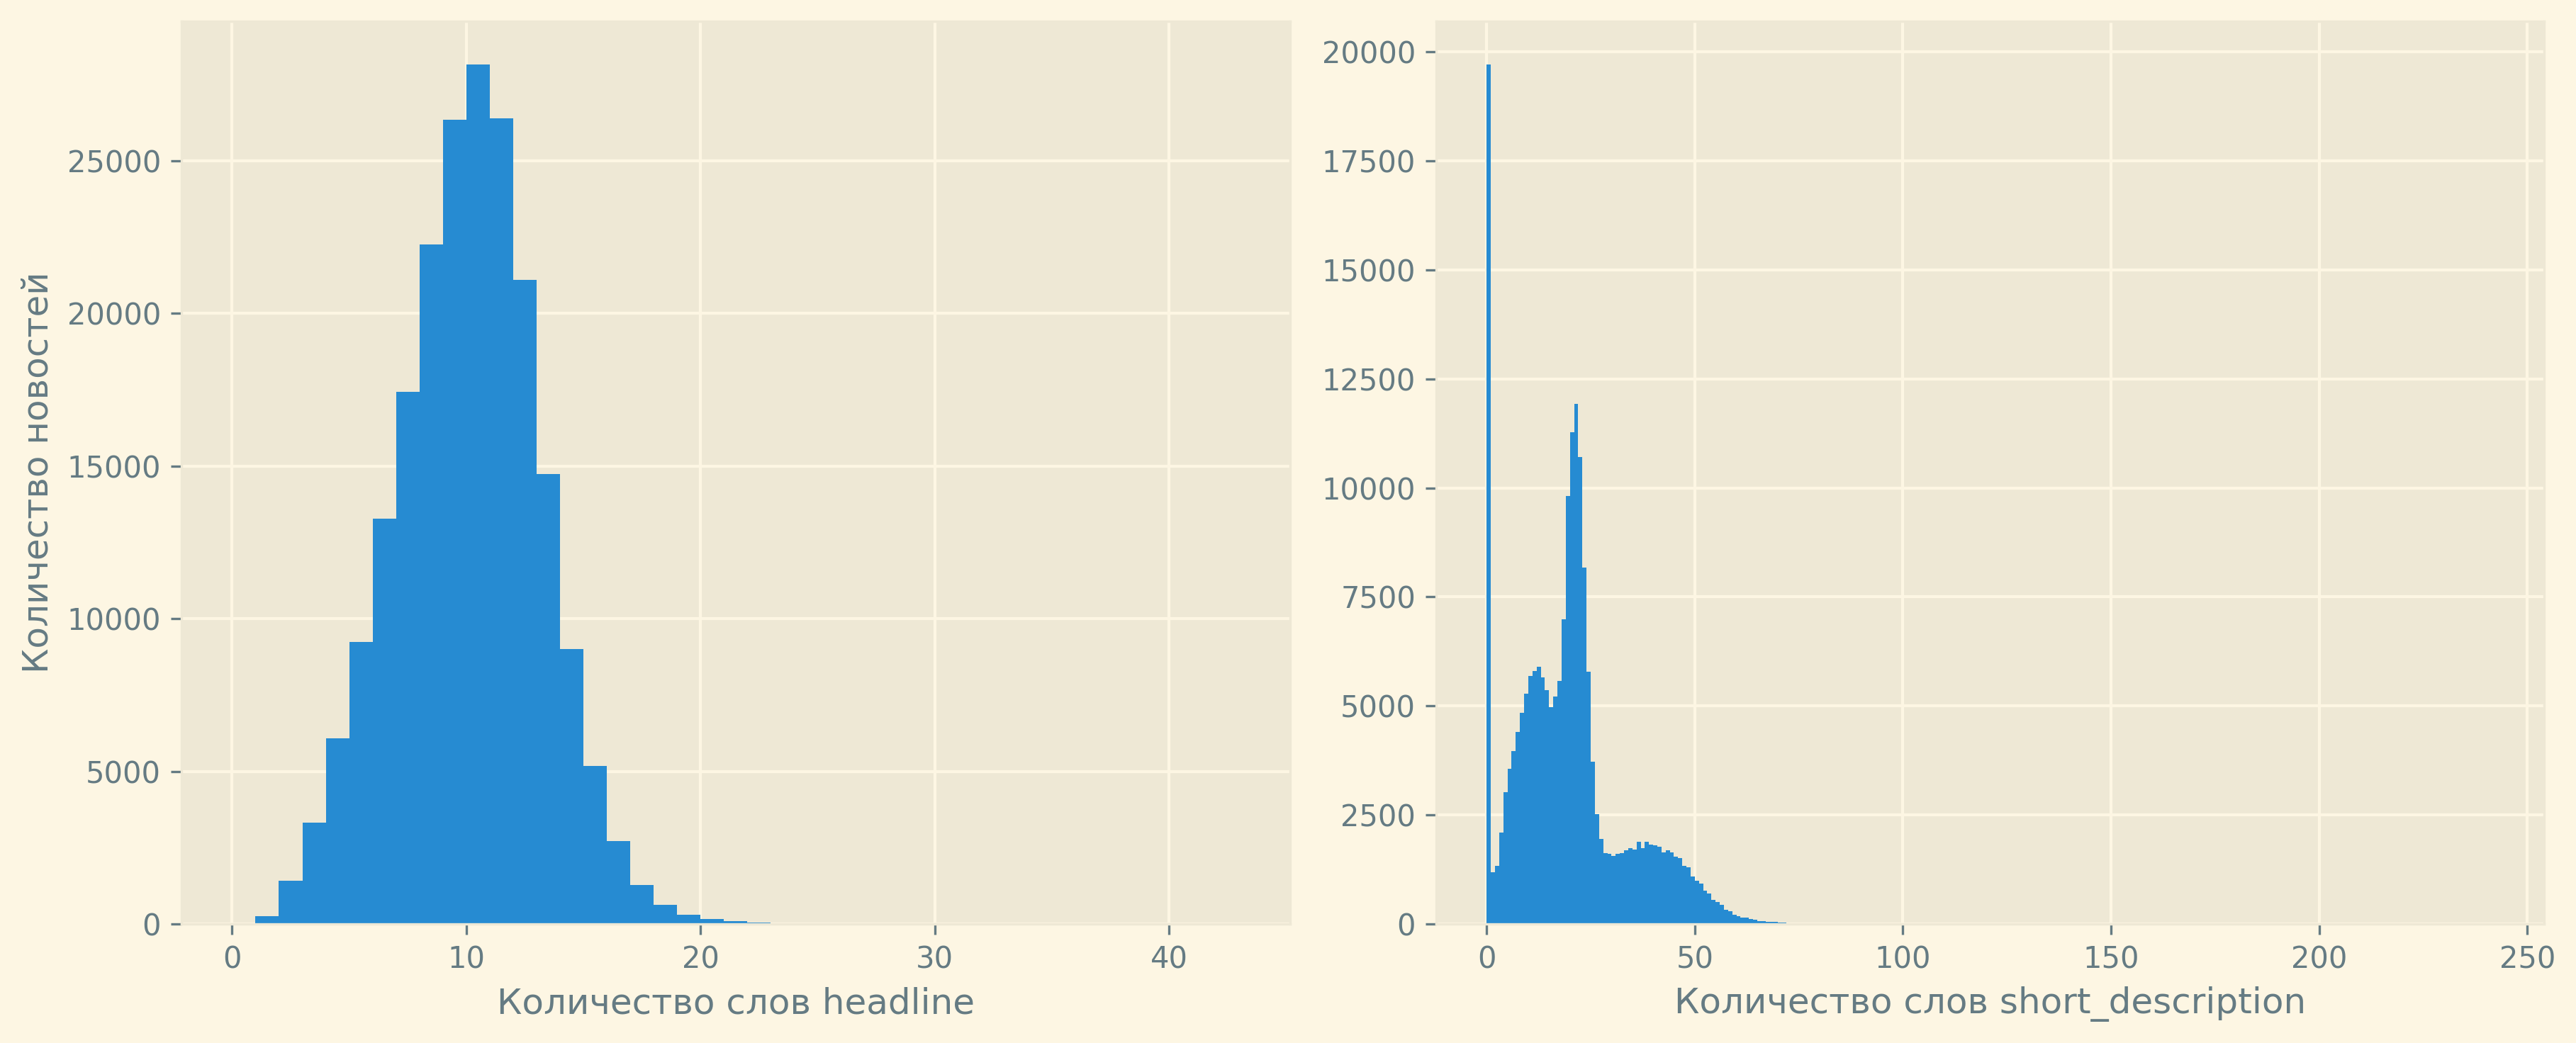

In [28]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(12, 5),
)

for i, col in enumerate(["headline", "short_description"]):
    ax = axs[i]
    features = data[col].str.split().apply(len)
    features.plot.hist(
        bins=range(features.max()),
        ax=ax,
    )
    # ax.set_title('Number of words in article description')
    ax.set_xlabel(f"Количество слов {col}")
    ax.set_ylabel(None)
    plt.tight_layout()

axs[0].set_ylabel(f"Количество новостей")

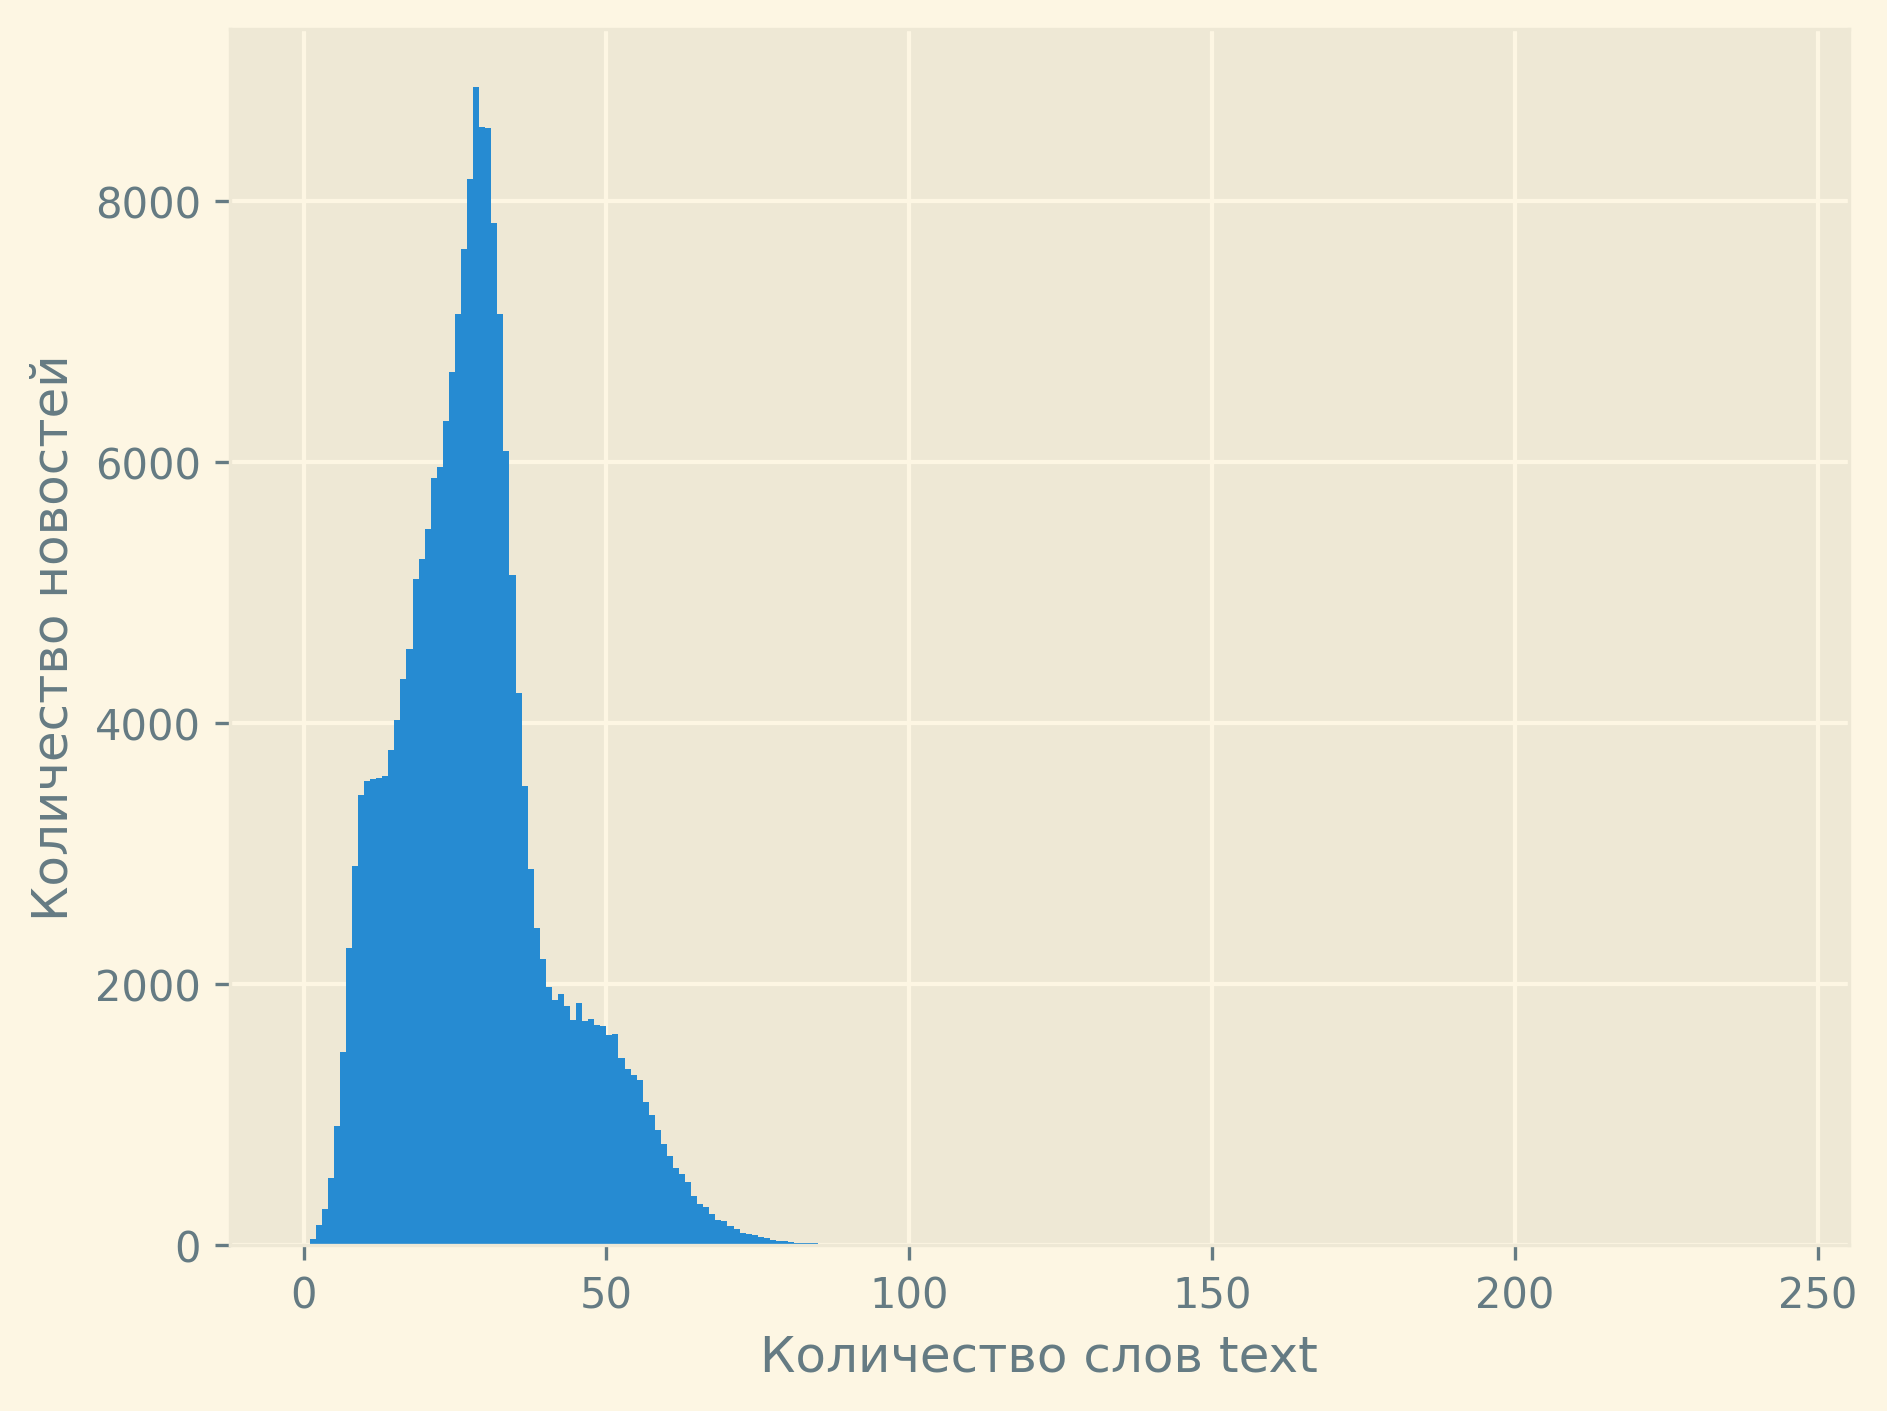

In [29]:
col = "text"

features = data[col].str.split().apply(len)
ax = features.plot.hist(
    bins=range(features.max()),
)
# ax.set_title('Number of words in article description')
ax.set_xlabel(f"Количество слов {col}")
ax.set_ylabel(f"Количество новостей")
plt.tight_layout()

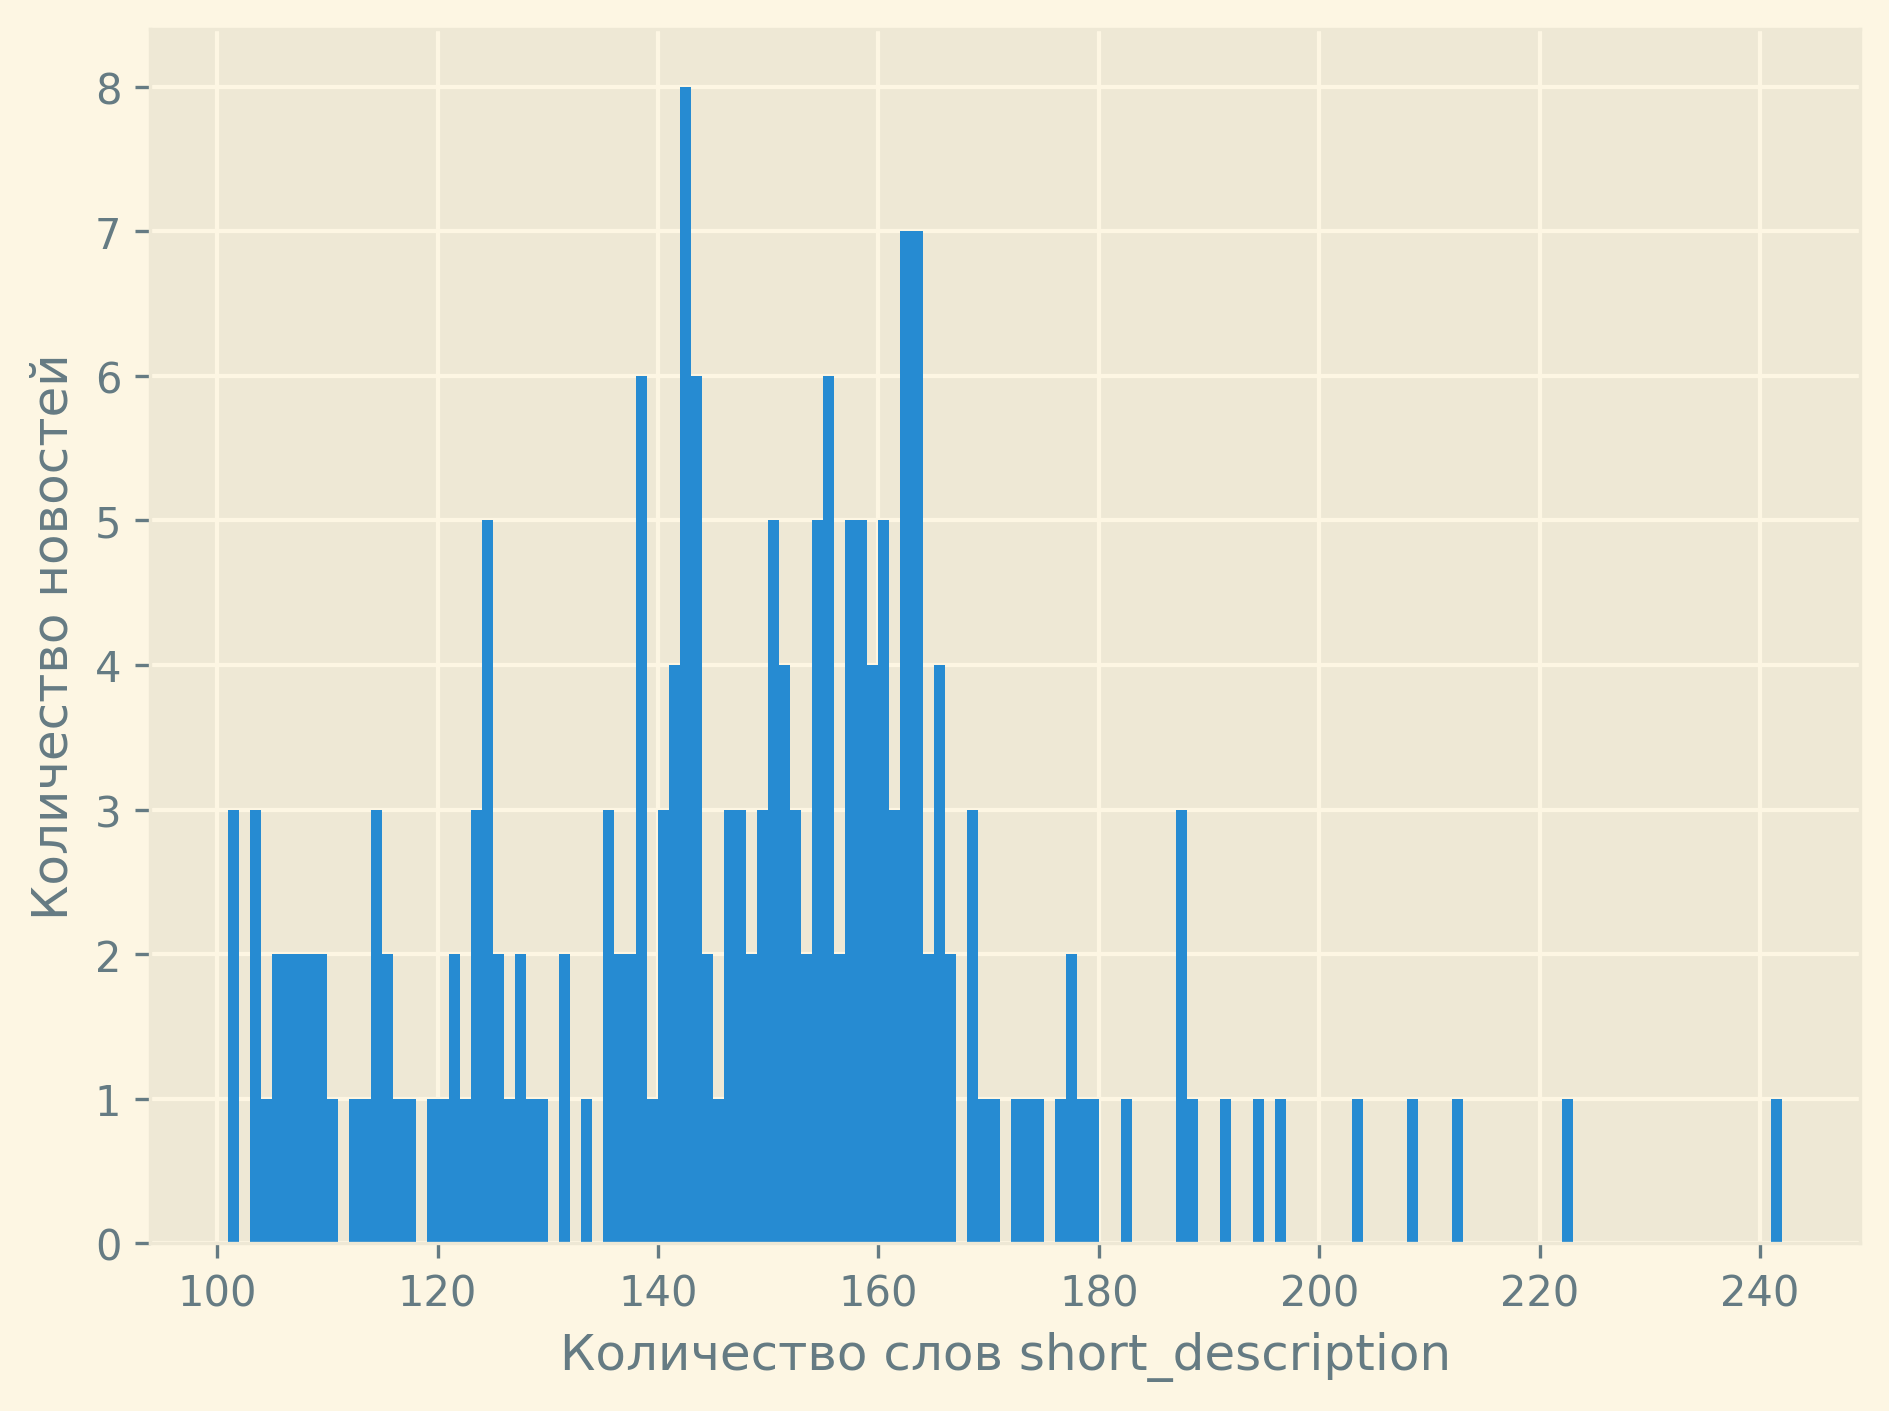

In [30]:
col = "short_description"

features = data[col].str.split().apply(len)
features = features[features > 100]

bins = range(features.min(), features.max())
ax = features.plot.hist(
    bins=bins,
)
# ax.set_title('Number of words in article description')
ax.set_xlabel(f"Количество слов {col}")
ax.set_ylabel(f"Количество новостей")
plt.tight_layout()

In [32]:
data["authors"].value_counts()

authors
                                                                          37418
Lee Moran                                                                  2954
Ron Dicker                                                                 2219
Ed Mazza                                                                   1590
Mary Papenfuss                                                             1566
                                                                          ...  
Holly Ramer, Associated Press                                                 1
Gina Carey, The Huffington Post                                               1
Randall Chase, Associated Press                                               1
Stephen Ohlemacher, AP                                                        1
John Giacobbi, Contributor\nTales from the Interweb by The Web Sheriff        1
Name: count, Length: 29169, dtype: int64

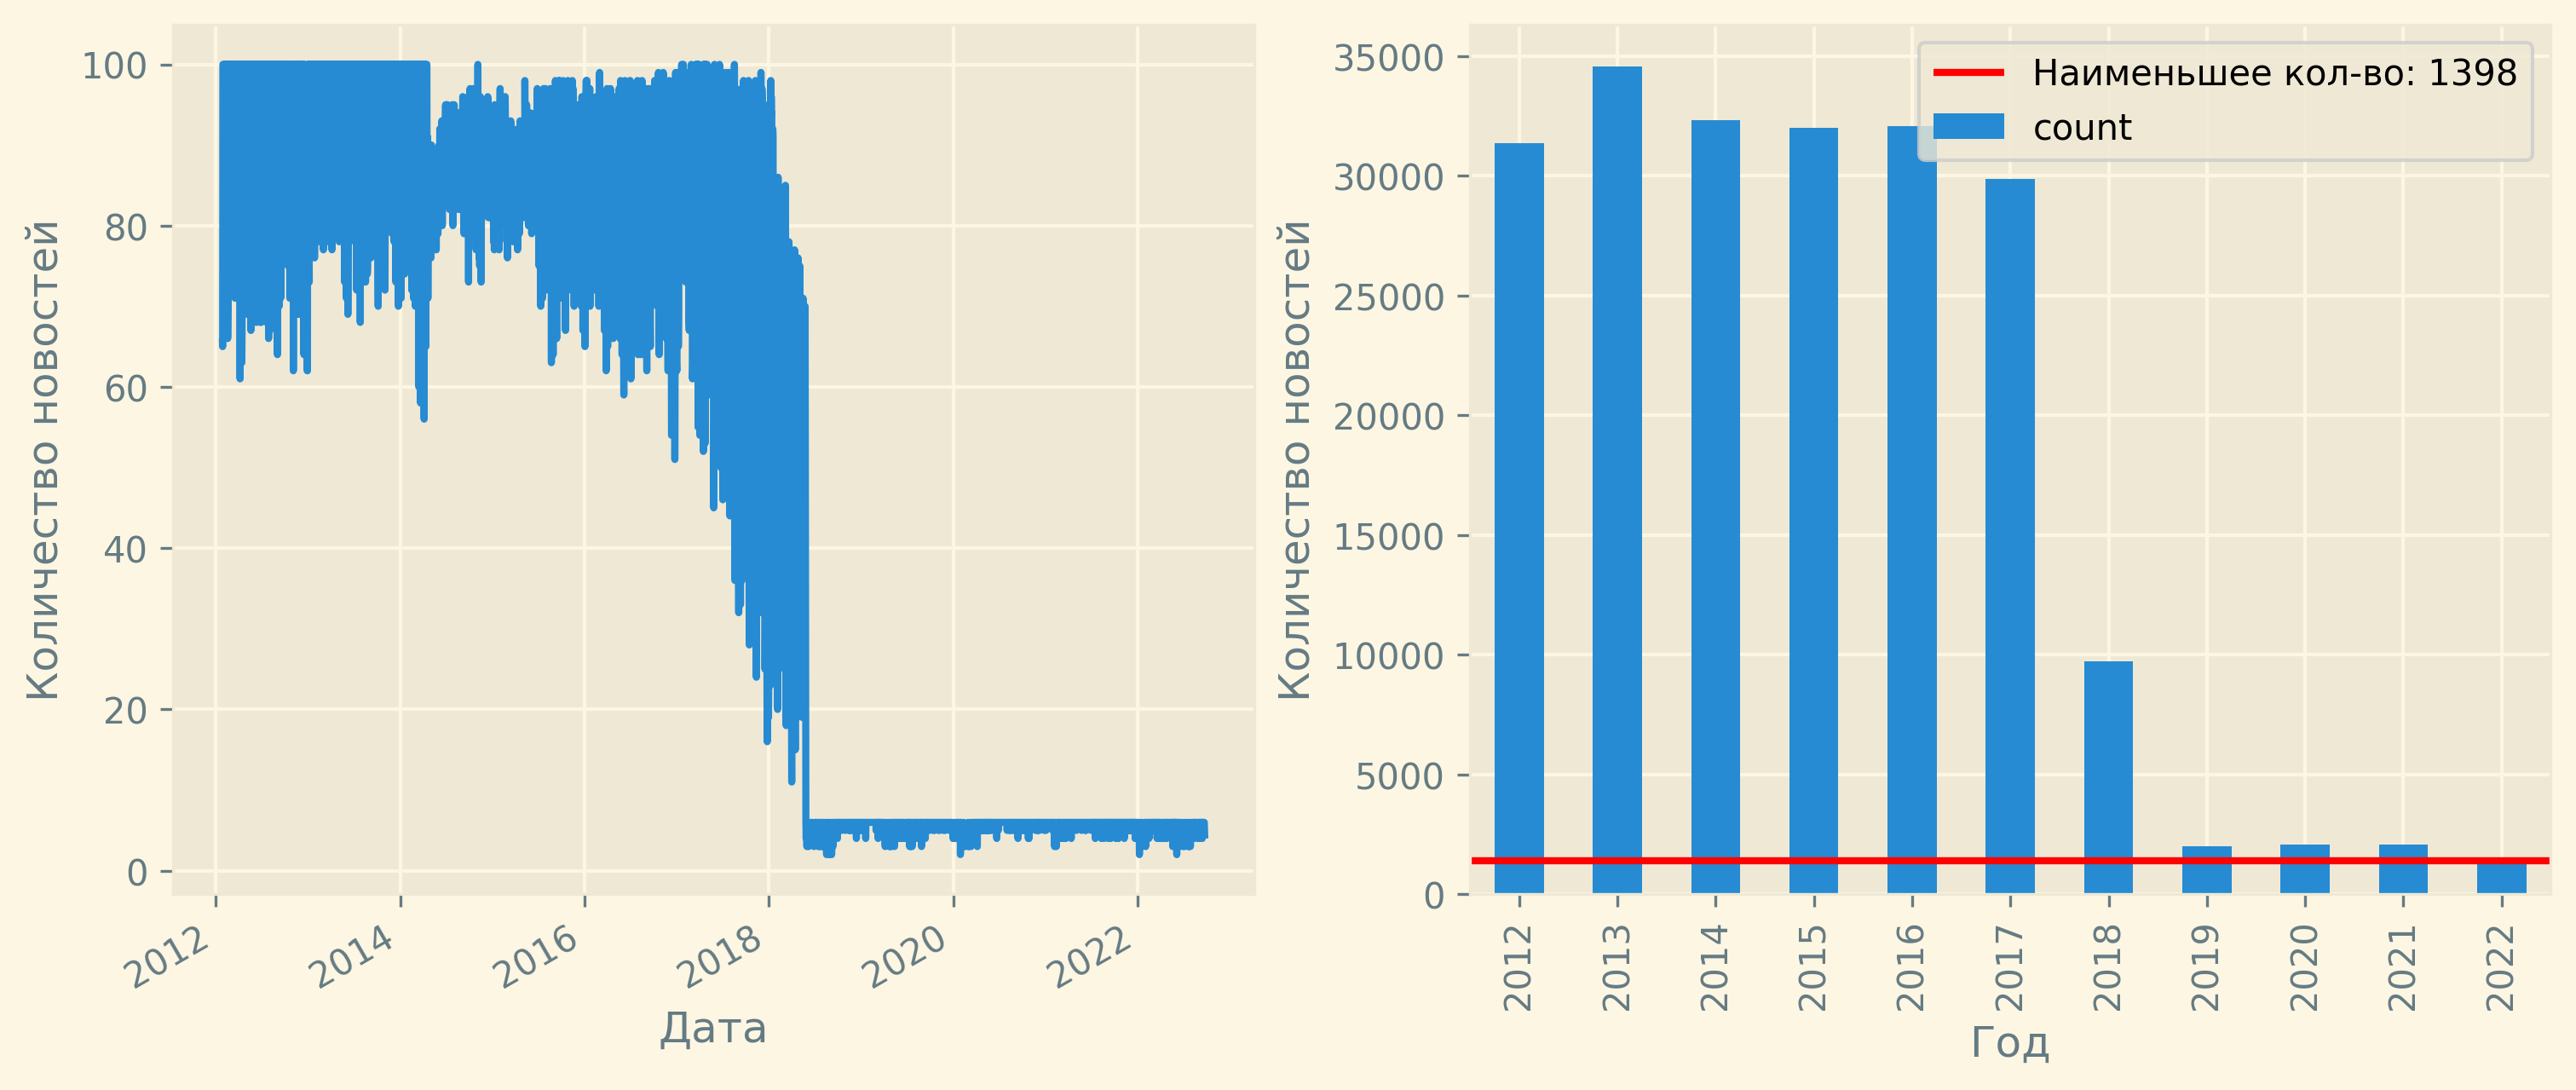

In [40]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(12, 5),
)

ax = axs[0]
date_counts = data["date"].value_counts()
date_counts.plot(ax=ax)
ax.set_xlabel("Дата")
ax.set_ylabel("Количество новостей")

ax = axs[1]
year_counts = data["date"].dt.year.value_counts()
year_counts.sort_index().plot.bar(ax=ax)
min_year_count = year_counts.min()
ax.axhline(
    min_year_count,
    color="red",
    label=f"Наименьшее кол-во: {min_year_count}",
)
ax.legend()
ax.set_xlabel("Год")
ax.set_ylabel("Количество новостей")

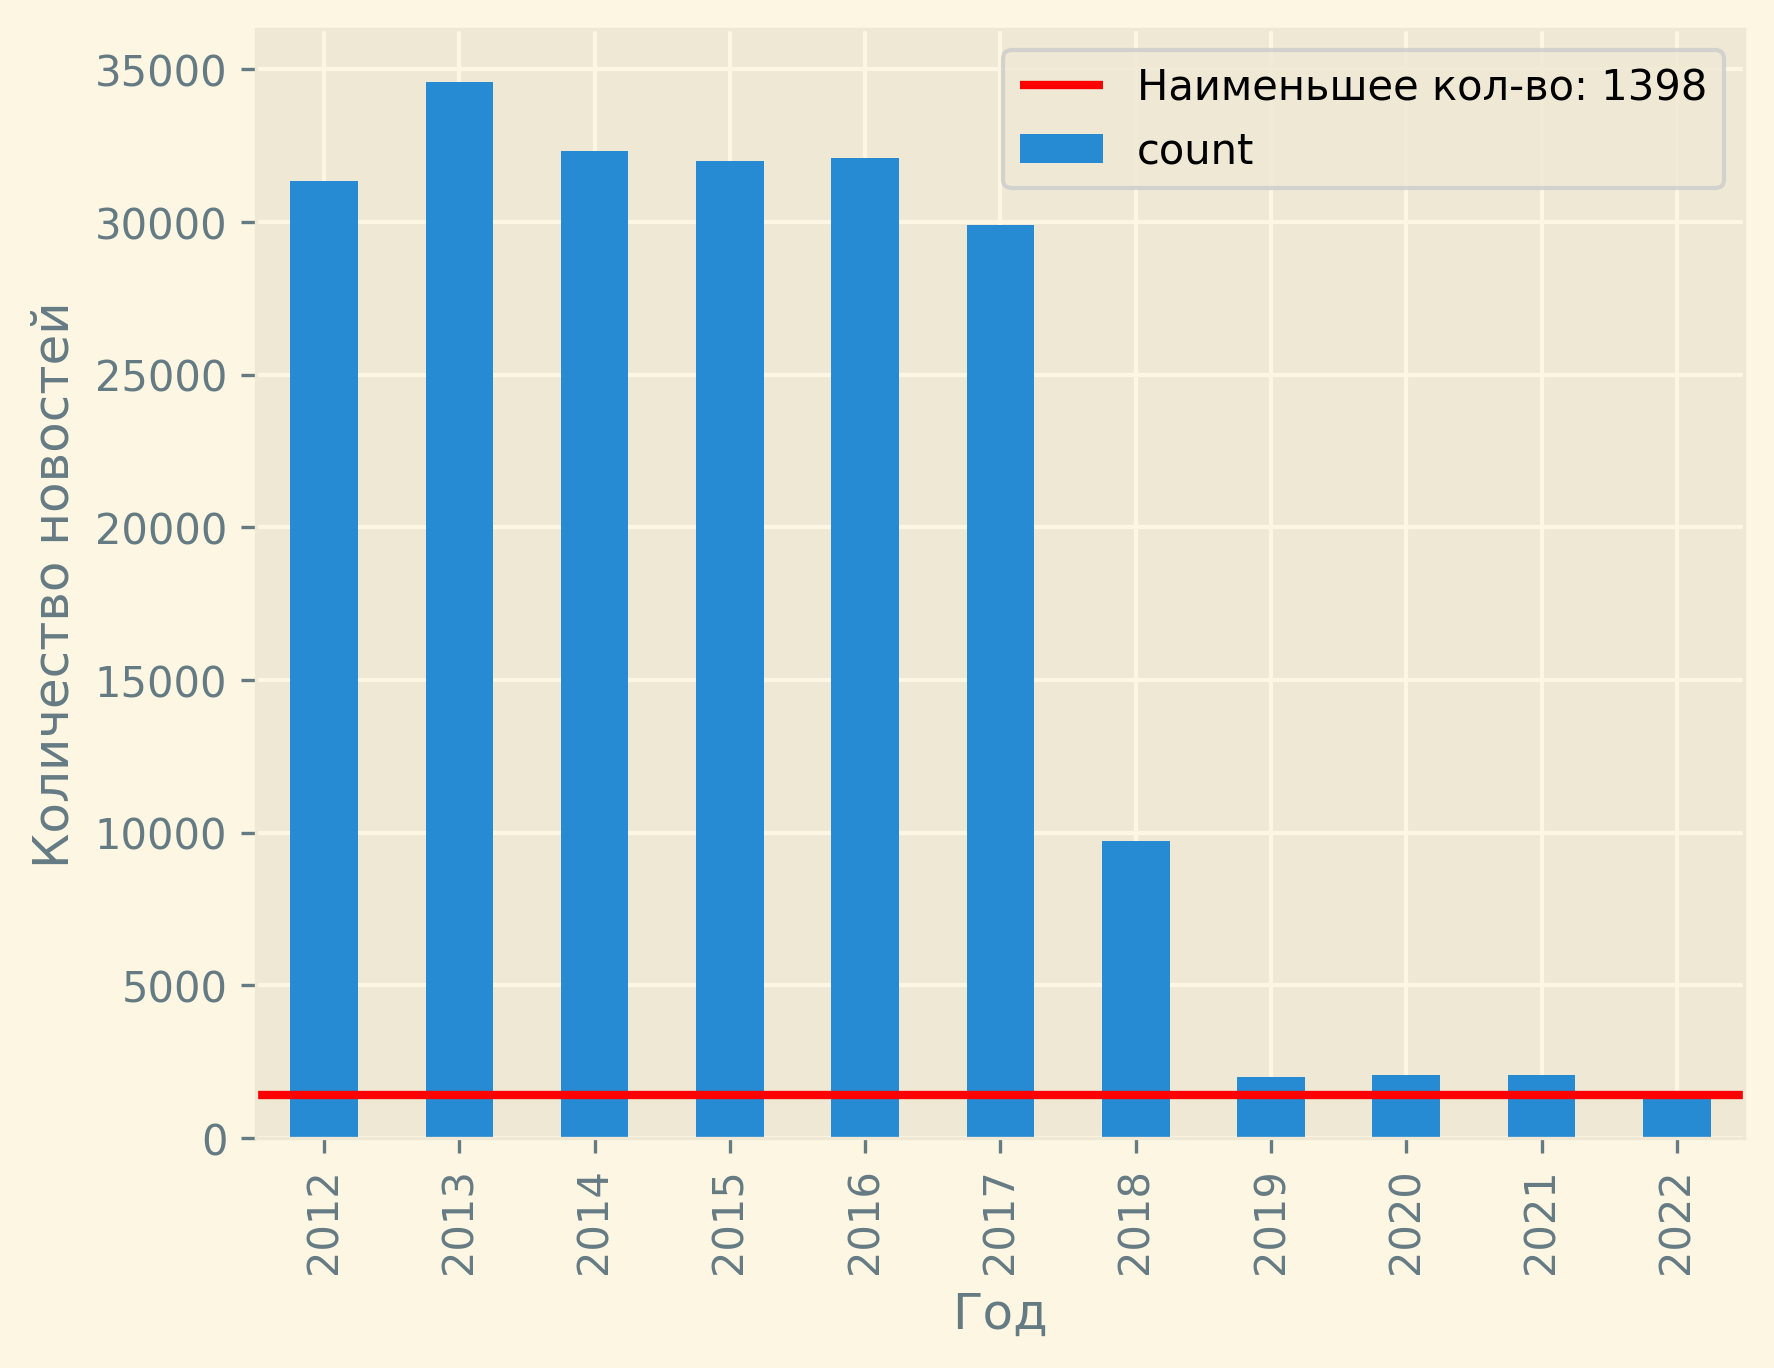

In [26]:
print(f"Количество новостей с 2013 по 2017: {year_counts[year_counts.index < 2018].sum():,}")
print(f"Количество новостей с 2018 по 2022: {year_counts[year_counts.index >= 2018].sum():,}")

Количество новостей с 2013 по 2017: 192,270
Количество новостей с 2018 по 2022: 17,257
